In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error, root_mean_squared_error
import matplotlib.pylab as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

import tensorflow as tf
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.layers import Dense, Input, Dropout
from keras._tf_keras.keras.regularizers import l2

np.random.seed(123)
tf.random.set_seed(123)

In [2]:
df0 = pd.read_csv('ETH-USD.csv', index_col=0, parse_dates=True)

In [3]:
df = df0[['Close']].copy()

In [4]:
df['LogClose'] = np.log(df['Close'])

In [5]:
df['DiffLogClose'] = df['LogClose'].diff()

In [6]:
Ntest = 10
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [7]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[['DiffLogClose']])
test_scaled = scaler.fit_transform(test[['DiffLogClose']])

In [8]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [9]:
df.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
df.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()

In [21]:
series = df['ScaledLogReturn'].dropna().to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t + T]
    X.append(x)
    y = series[t + T]
    Y.append(y)
X = np.array(X).reshape(-1,T)
Y = np.array(Y)
N = len(X)
print('X.shape', X.shape, 'Y.shape', Y.shape)

X.shape (1817, 10) Y.shape (1817,)


In [22]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [23]:
def build_model(units=50, optimizer='adam', activation='relu',dropout_rate=0.2, regularization_rate=0.01):
    i = Input(shape=(T,))
    x = Dense(units, activation=activation)(i)  
    x = Dropout(dropout_rate)(x)  
    x = Dense(units, activation=activation, kernel_regularizer=l2(regularization_rate))(x)  
    x = Dense(1)(x) 
    model = Model(inputs=i, outputs=x)
    model.compile(loss='mape', optimizer=optimizer)
    return model

In [24]:
model = KerasRegressor(model=build_model, verbose=2)

In [25]:
param_grid = {
    'model__units': [32, 64],  
    'model__activation': ['relu', 'tanh'],  
    'model__optimizer': ['adam', 'rmsprop'],  
    'model__dropout_rate': [0.1, 0.2], 
    'model__regularization_rate': [0.01, 0.001], 
    'epochs': [50, 100],
}

In [26]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=2)
grid_result = grid.fit(Xtrain, Ytrain,validation_data=(Xtest, Ytest))
best_model = grid_result.best_estimator_

Fitting 2 folds for each of 64 candidates, totalling 128 fits
Epoch 1/50
57/57 - 2s - 44ms/step - loss: 168.0400 - val_loss: 117.4252
Epoch 2/50
57/57 - 0s - 4ms/step - loss: 142.2367 - val_loss: 103.3968
Epoch 3/50
57/57 - 0s - 4ms/step - loss: 134.2897 - val_loss: 97.6603
Epoch 4/50
57/57 - 0s - 4ms/step - loss: 141.5654 - val_loss: 99.9835
Epoch 5/50
57/57 - 0s - 3ms/step - loss: 131.0572 - val_loss: 126.3293
Epoch 6/50
57/57 - 0s - 4ms/step - loss: 124.1075 - val_loss: 135.1728
Epoch 7/50
57/57 - 0s - 3ms/step - loss: 129.2847 - val_loss: 88.8531
Epoch 8/50
57/57 - 0s - 5ms/step - loss: 125.6241 - val_loss: 90.1417
Epoch 9/50
57/57 - 0s - 4ms/step - loss: 125.9261 - val_loss: 106.9825
Epoch 10/50
57/57 - 0s - 4ms/step - loss: 119.6384 - val_loss: 95.2833
Epoch 11/50
57/57 - 0s - 6ms/step - loss: 124.2580 - val_loss: 85.1742
Epoch 12/50
57/57 - 0s - 4ms/step - loss: 131.3417 - val_loss: 96.1248
Epoch 13/50
57/57 - 0s - 4ms/step - loss: 123.8458 - val_loss: 85.5530
Epoch 14/50
57/57 

In [27]:
last_train = train.iloc[-1]['LogClose']

In [29]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = best_model.predict(last_x.reshape(1, -1))[0]
  
  # update the predictions list
  multistep_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

1/1 - 0s - 109ms/step
1/1 - 0s - 47ms/step
1/1 - 0s - 47ms/step
1/1 - 0s - 47ms/step
1/1 - 0s - 47ms/step
1/1 - 0s - 66ms/step
1/1 - 0s - 47ms/step
1/1 - 0s - 31ms/step
1/1 - 0s - 47ms/step
1/1 - 0s - 45ms/step


In [30]:
multistep_predictions = np.array(multistep_predictions)
multistep_predictions = scaler.inverse_transform(
    multistep_predictions.reshape(-1, 1)).flatten()

In [31]:
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

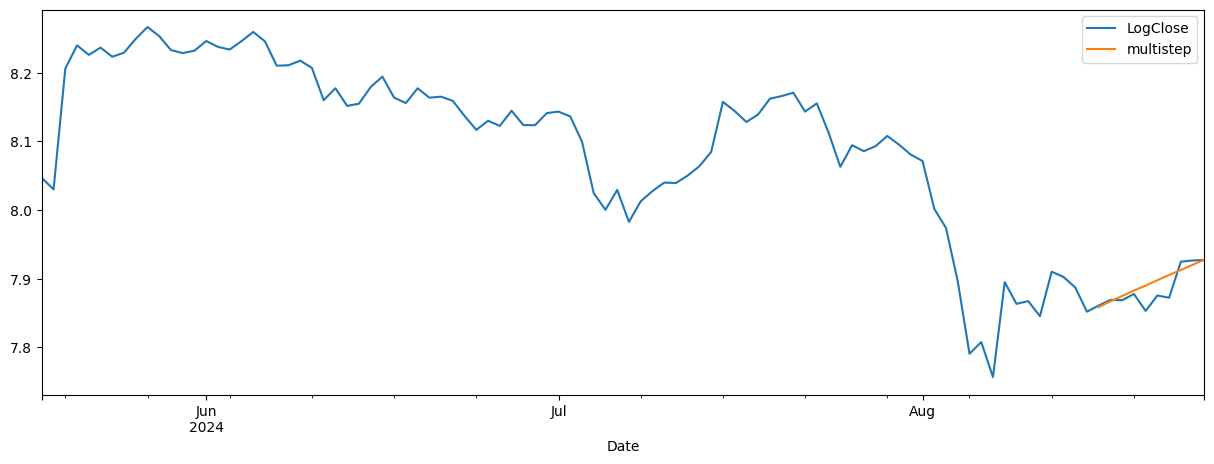

In [32]:
df.iloc[-100:][['LogClose', 'multistep']].plot(figsize=(15, 5));

X.shape (317, 10) Y.shape (317,)
Fitting 2 folds for each of 64 candidates, totalling 128 fits
Epoch 1/100
10/10 - 3s - 291ms/step - loss: 819.5700 - val_loss: 133.7272
Epoch 2/100
10/10 - 0s - 14ms/step - loss: 619.7438 - val_loss: 102.3705
Epoch 3/100
10/10 - 0s - 22ms/step - loss: 672.4581 - val_loss: 91.3566
Epoch 4/100
10/10 - 0s - 11ms/step - loss: 594.3312 - val_loss: 100.1711
Epoch 5/100
10/10 - 0s - 12ms/step - loss: 485.6889 - val_loss: 102.4486
Epoch 6/100
10/10 - 0s - 11ms/step - loss: 326.6844 - val_loss: 116.7421
Epoch 7/100
10/10 - 0s - 26ms/step - loss: 276.3028 - val_loss: 124.8392
Epoch 8/100
10/10 - 0s - 11ms/step - loss: 289.8096 - val_loss: 130.8728
Epoch 9/100
10/10 - 0s - 12ms/step - loss: 323.6286 - val_loss: 126.8375
Epoch 10/100
10/10 - 0s - 11ms/step - loss: 404.1021 - val_loss: 118.1842
Epoch 11/100
10/10 - 0s - 11ms/step - loss: 695.5090 - val_loss: 106.7564
Epoch 12/100
10/10 - 0s - 11ms/step - loss: 261.0042 - val_loss: 98.8980
Epoch 13/100
10/10 - 0s - 1

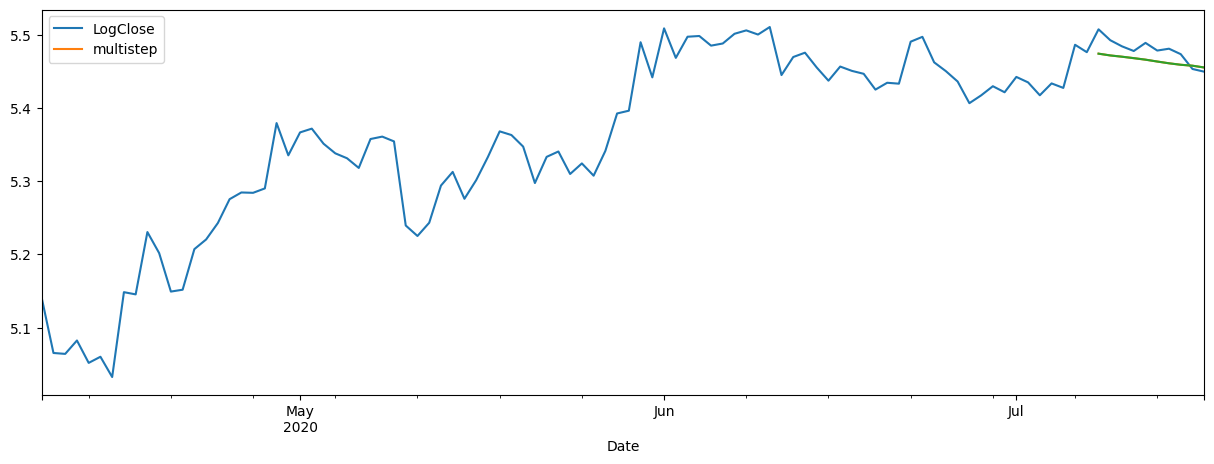

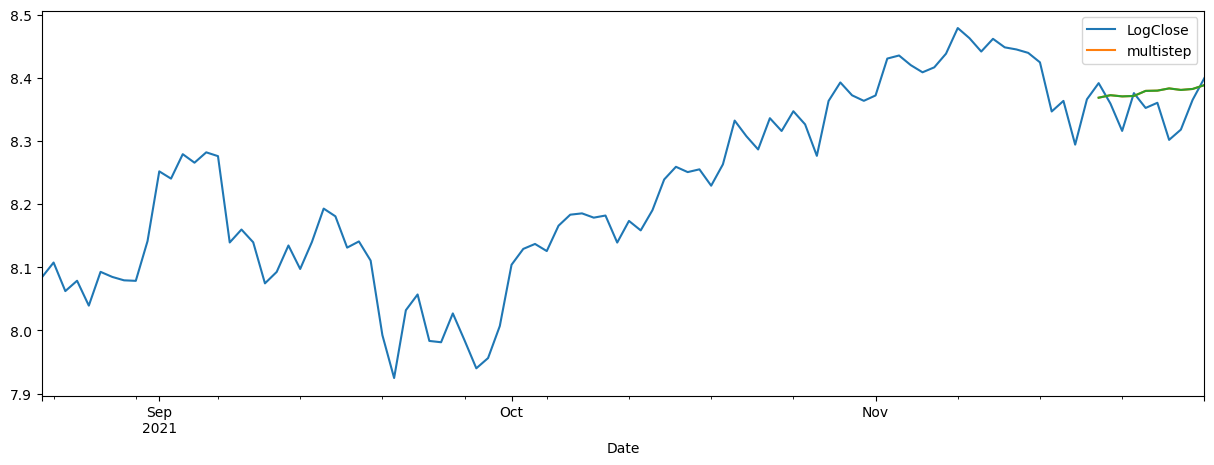

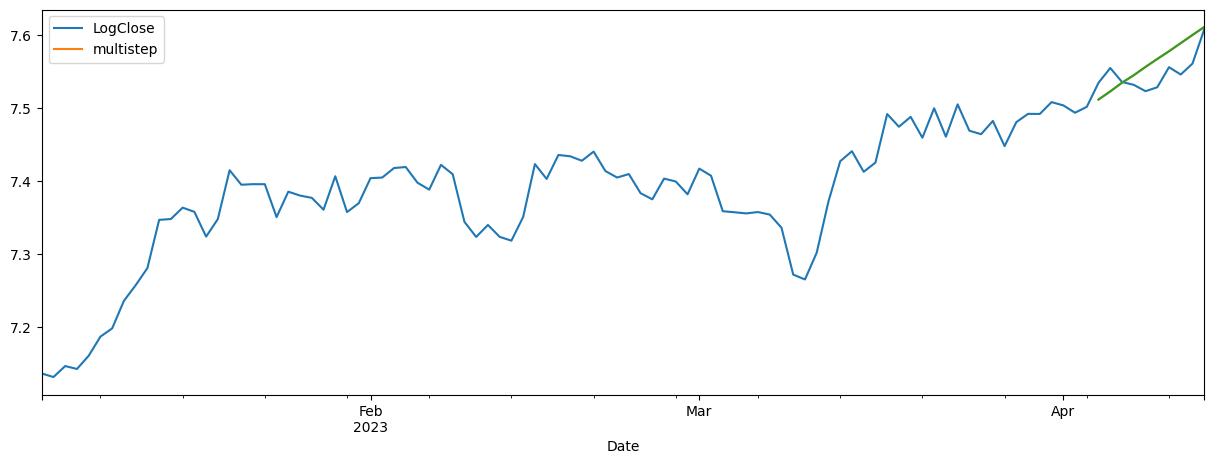

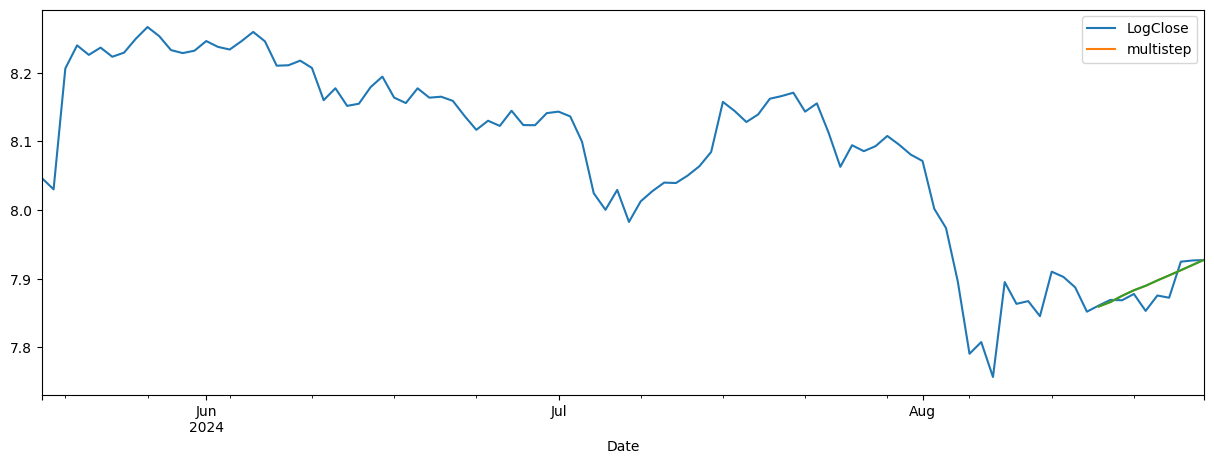

In [34]:
i = 328
real_10d = []
pred_10d = []
while i <= len(df):
    temp = df[:i].copy()
    
    i = i + 500
    
    Ntest = 10
    train = temp.iloc[:-Ntest]
    test = temp.iloc[-Ntest:]
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[['DiffLogClose']])
    test_scaled = scaler.fit_transform(test[['DiffLogClose']])
    
    train_idx = temp.index <= train.index[-1]
    test_idx = temp.index > train.index[-1]
    
    temp.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
    temp.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()
    
    series = temp['ScaledLogReturn'].dropna().to_numpy()

    T = 10
    X = []
    Y = []
    for t in range(len(series) - T):
        x = series[t:t + T]
        X.append(x)
        y = series[t + T]
        Y.append(y)
    X = np.array(X).reshape(-1,T)
    Y = np.array(Y)
    N = len(X)
    print('X.shape', X.shape, 'Y.shape', Y.shape)
    
    Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
    Xtest, Ytest = X[-Ntest:], Y[-Ntest:]
    
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=2)
    grid_result = grid.fit(Xtrain, Ytrain,validation_data=(Xtest, Ytest))
    best_model = grid_result.best_estimator_
    
    last_train = train.iloc[-1]['LogClose']
    
    # multi-step forecast
    multistep_predictions = []
    
    # first test input
    last_x = Xtest[0]
    
    while len(multistep_predictions) < Ntest:
      p = best_model.predict(last_x.reshape(1, -1))[0]
      
      # update the predictions list
      multistep_predictions.append(p)
      
      # make the new input
      last_x = np.roll(last_x, -1)
      last_x[-1] = p
    
    multistep_predictions = np.array(multistep_predictions)
    multistep_predictions = scaler.inverse_transform(multistep_predictions.reshape(-1, 1)).flatten()
    
    temp.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)
    
    predicted_temp = np.array(np.exp(temp.loc[test_idx,'multistep']))
    real_temp = np.array(temp.loc[test_idx,'Close'])
    
    temp.iloc[-100:][['LogClose', 'multistep']].plot(figsize=(15, 5));
    plt.plot(temp.loc[test_idx, 'multistep'])
    
    pred_10d.append(predicted_temp)
    real_10d.append(real_temp)

X.shape (277, 50) Y.shape (277,)
Fitting 2 folds for each of 64 candidates, totalling 128 fits
Epoch 1/100
9/9 - 2s - 275ms/step - loss: 642.7778 - val_loss: 216.2697
Epoch 2/100
9/9 - 0s - 16ms/step - loss: 521.1130 - val_loss: 201.0995
Epoch 3/100
9/9 - 0s - 14ms/step - loss: 515.3376 - val_loss: 183.0254
Epoch 4/100
9/9 - 0s - 16ms/step - loss: 496.0894 - val_loss: 171.1261
Epoch 5/100
9/9 - 0s - 14ms/step - loss: 629.3649 - val_loss: 173.0951
Epoch 6/100
9/9 - 0s - 14ms/step - loss: 438.9550 - val_loss: 178.1448
Epoch 7/100
9/9 - 0s - 16ms/step - loss: 422.3285 - val_loss: 180.7162
Epoch 8/100
9/9 - 0s - 14ms/step - loss: 474.4137 - val_loss: 170.7992
Epoch 9/100
9/9 - 0s - 16ms/step - loss: 264.3708 - val_loss: 166.4877
Epoch 10/100
9/9 - 0s - 14ms/step - loss: 743.7797 - val_loss: 154.8717
Epoch 11/100
9/9 - 0s - 14ms/step - loss: 359.7377 - val_loss: 161.7990
Epoch 12/100
9/9 - 0s - 16ms/step - loss: 403.7205 - val_loss: 167.7507
Epoch 13/100
9/9 - 0s - 16ms/step - loss: 232.531

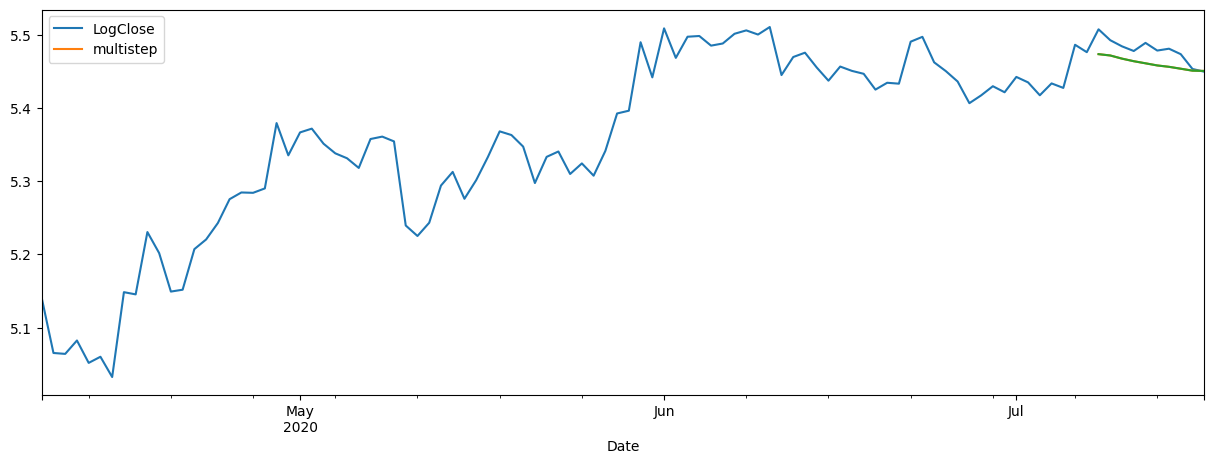

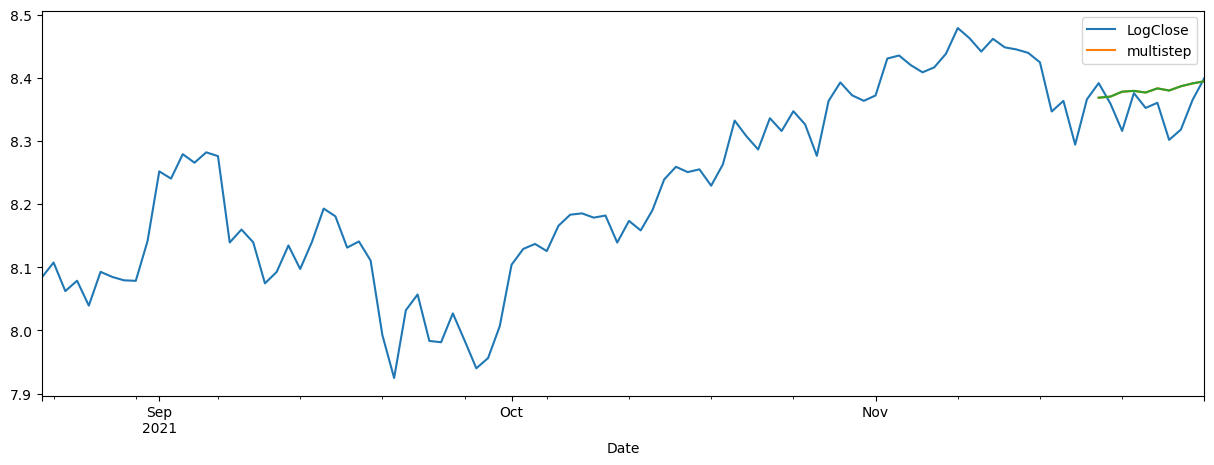

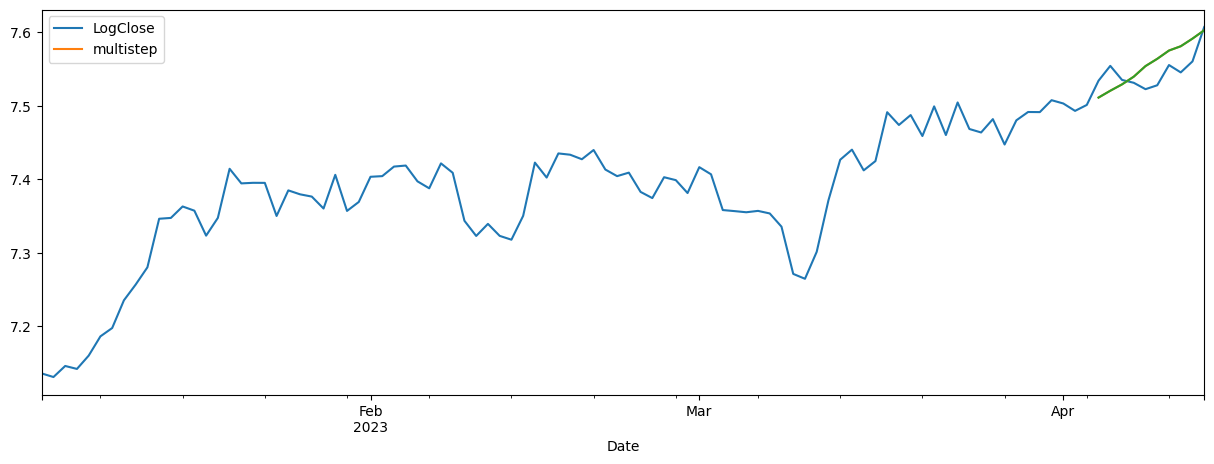

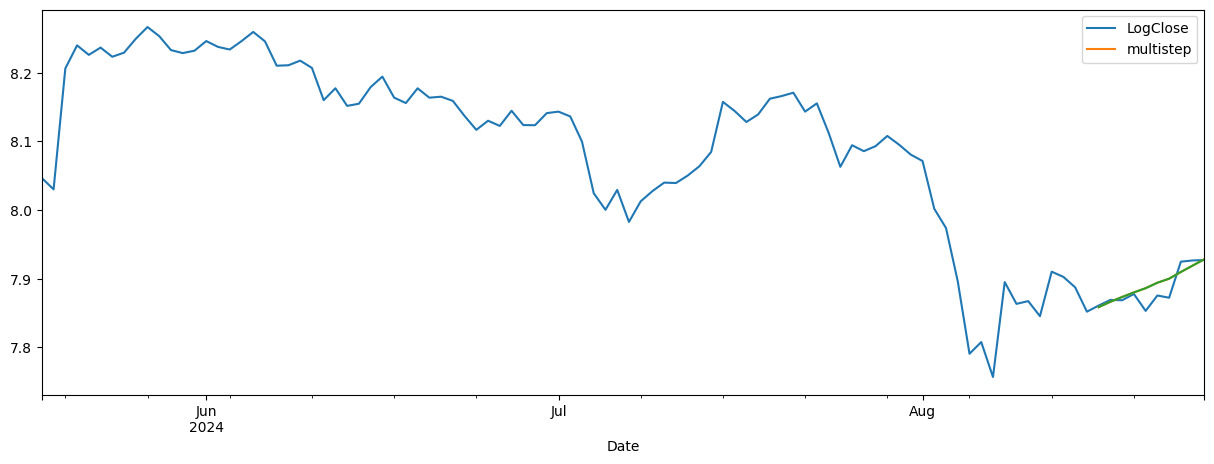

In [43]:
i = 328
real_50d = []
pred_50d = []
while i <= len(df):
    temp = df[:i].copy()
    
    i = i + 500
    
    Ntest = 10
    train = temp.iloc[:-Ntest]
    test = temp.iloc[-Ntest:]
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[['DiffLogClose']])
    test_scaled = scaler.fit_transform(test[['DiffLogClose']])
    
    train_idx = temp.index <= train.index[-1]
    test_idx = temp.index > train.index[-1]
    
    temp.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
    temp.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()
    
    series = temp['ScaledLogReturn'].dropna().to_numpy()

    T = 50
    X = []
    Y = []
    for t in range(len(series) - T):
        x = series[t:t + T]
        X.append(x)
        y = series[t + T]
        Y.append(y)
    X = np.array(X).reshape(-1,T)
    Y = np.array(Y)
    N = len(X)
    print('X.shape', X.shape, 'Y.shape', Y.shape)
    
    Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
    Xtest, Ytest = X[-Ntest:], Y[-Ntest:]
    
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=2)
    grid_result = grid.fit(Xtrain, Ytrain,validation_data=(Xtest, Ytest))
    best_model = grid_result.best_estimator_
    
    last_train = train.iloc[-1]['LogClose']
    
    # multi-step forecast
    multistep_predictions = []
    
    # first test input
    last_x = Xtest[0]
    
    while len(multistep_predictions) < Ntest:
      p = best_model.predict(last_x.reshape(1, -1))[0]
      
      # update the predictions list
      multistep_predictions.append(p)
      
      # make the new input
      last_x = np.roll(last_x, -1)
      last_x[-1] = p
    
    multistep_predictions = np.array(multistep_predictions)
    multistep_predictions = scaler.inverse_transform(multistep_predictions.reshape(-1, 1)).flatten()
    
    temp.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)
    
    predicted_temp = np.array(np.exp(temp.loc[test_idx,'multistep']))
    real_temp = np.array(temp.loc[test_idx,'Close'])
    
    temp.iloc[-100:][['LogClose', 'multistep']].plot(figsize=(15, 5));
    plt.plot(temp.loc[test_idx, 'multistep'])
    
    pred_50d.append(predicted_temp)
    real_50d.append(real_temp)

X.shape (227, 100) Y.shape (227,)
Fitting 2 folds for each of 64 candidates, totalling 128 fits
Epoch 1/100
7/7 - 4s - 592ms/step - loss: 773.1716 - val_loss: 152.4934
Epoch 2/100
7/7 - 0s - 18ms/step - loss: 996.6454 - val_loss: 144.5592
Epoch 3/100
7/7 - 0s - 18ms/step - loss: 587.6959 - val_loss: 140.8359
Epoch 4/100
7/7 - 0s - 16ms/step - loss: 624.4071 - val_loss: 134.3610
Epoch 5/100
7/7 - 0s - 18ms/step - loss: 615.7347 - val_loss: 133.8757
Epoch 6/100
7/7 - 0s - 16ms/step - loss: 661.0385 - val_loss: 138.0049
Epoch 7/100
7/7 - 0s - 16ms/step - loss: 608.1740 - val_loss: 127.2409
Epoch 8/100
7/7 - 0s - 18ms/step - loss: 721.7311 - val_loss: 134.5551
Epoch 9/100
7/7 - 0s - 16ms/step - loss: 446.5312 - val_loss: 124.6641
Epoch 10/100
7/7 - 0s - 16ms/step - loss: 545.2153 - val_loss: 127.9113
Epoch 11/100
7/7 - 0s - 18ms/step - loss: 650.3867 - val_loss: 120.2781
Epoch 12/100
7/7 - 0s - 18ms/step - loss: 471.3167 - val_loss: 120.6682
Epoch 13/100
7/7 - 0s - 18ms/step - loss: 364.15

C:\Users\Korisnik\Desktop\Diplomski\Eth_price_prediciton\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/100
39/39 - 3s - 67ms/step - loss: 828.2856 - val_loss: 93.5268
Epoch 2/100
39/39 - 0s - 5ms/step - loss: 601.5259 - val_loss: 97.7257
Epoch 3/100
39/39 - 0s - 4ms/step - loss: 511.5415 - val_loss: 99.9332
Epoch 4/100
39/39 - 0s - 5ms/step - loss: 535.5618 - val_loss: 100.4310
Epoch 5/100
39/39 - 0s - 5ms/step - loss: 474.1540 - val_loss: 98.9562
Epoch 6/100
39/39 - 0s - 5ms/step - loss: 482.3372 - val_loss: 95.8064
Epoch 7/100
39/39 - 0s - 4ms/step - loss: 372.1007 - val_loss: 97.5693
Epoch 8/100
39/39 - 0s - 4ms/step - loss: 483.0824 - val_loss: 94.1721
Epoch 9/100
39/39 - 0s - 4ms/step - loss: 457.8328 - val_loss: 99.2986
Epoch 10/100
39/39 - 0s - 4ms/step - loss: 389.5309 - val_loss: 91.7969
Epoch 11/100
39/39 - 0s - 4ms/step - loss: 364.2101 - val_loss: 93.0925
Epoch 12/100
39/39 - 0s - 4ms/step - loss: 487.5301 - val_loss: 95.2829
Epoch 13/100
39/39 - 0s - 4ms/step - loss: 316.8973 - val_loss: 93.9984
Epoch 14/100
39/39 - 0s - 5ms/step - loss: 382.9859 - val_loss: 89.6352

C:\Users\Korisnik\Desktop\Diplomski\Eth_price_prediciton\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/100
54/54 - 3s - 53ms/step - loss: 406.1031 - val_loss: 295.7713
Epoch 2/100
54/54 - 0s - 4ms/step - loss: 485.5481 - val_loss: 178.0690
Epoch 3/100
54/54 - 0s - 4ms/step - loss: 213.7513 - val_loss: 163.4735
Epoch 4/100
54/54 - 0s - 4ms/step - loss: 342.8221 - val_loss: 154.5602
Epoch 5/100
54/54 - 0s - 4ms/step - loss: 201.7795 - val_loss: 111.8854
Epoch 6/100
54/54 - 0s - 4ms/step - loss: 280.5699 - val_loss: 113.3883
Epoch 7/100
54/54 - 0s - 4ms/step - loss: 178.0050 - val_loss: 117.7750
Epoch 8/100
54/54 - 0s - 4ms/step - loss: 219.1339 - val_loss: 122.2685
Epoch 9/100
54/54 - 0s - 4ms/step - loss: 189.6890 - val_loss: 144.2693
Epoch 10/100
54/54 - 0s - 4ms/step - loss: 265.6603 - val_loss: 85.4710
Epoch 11/100
54/54 - 0s - 4ms/step - loss: 221.7638 - val_loss: 108.1578
Epoch 12/100
54/54 - 0s - 4ms/step - loss: 215.3110 - val_loss: 94.9972
Epoch 13/100
54/54 - 0s - 4ms/step - loss: 197.0567 - val_loss: 115.2715
Epoch 14/100
54/54 - 0s - 4ms/step - loss: 182.2248 - val_los

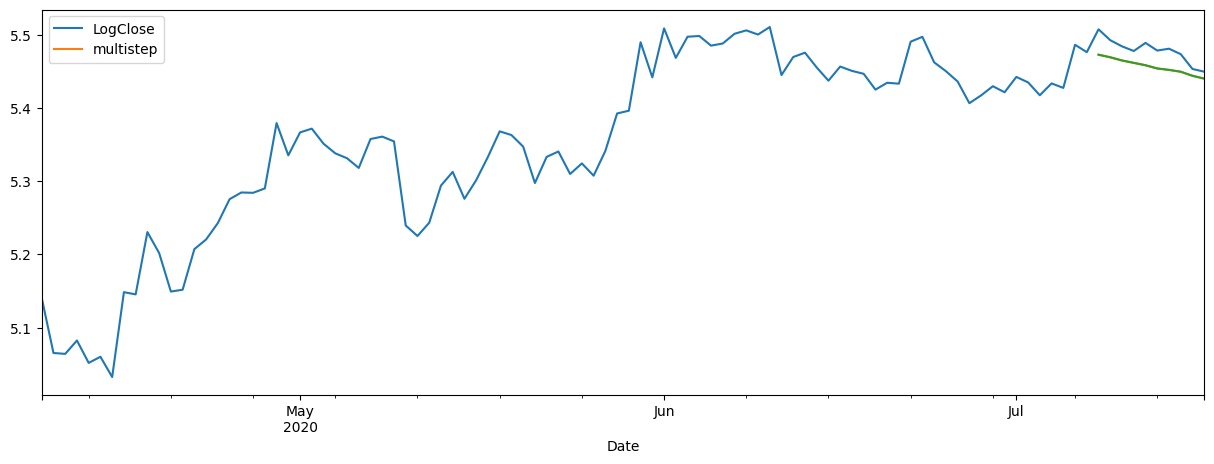

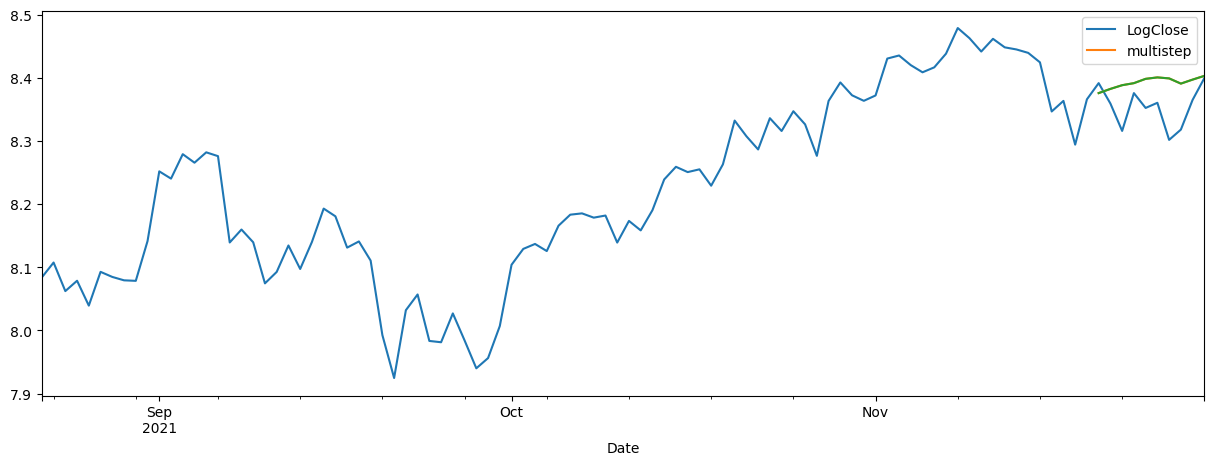

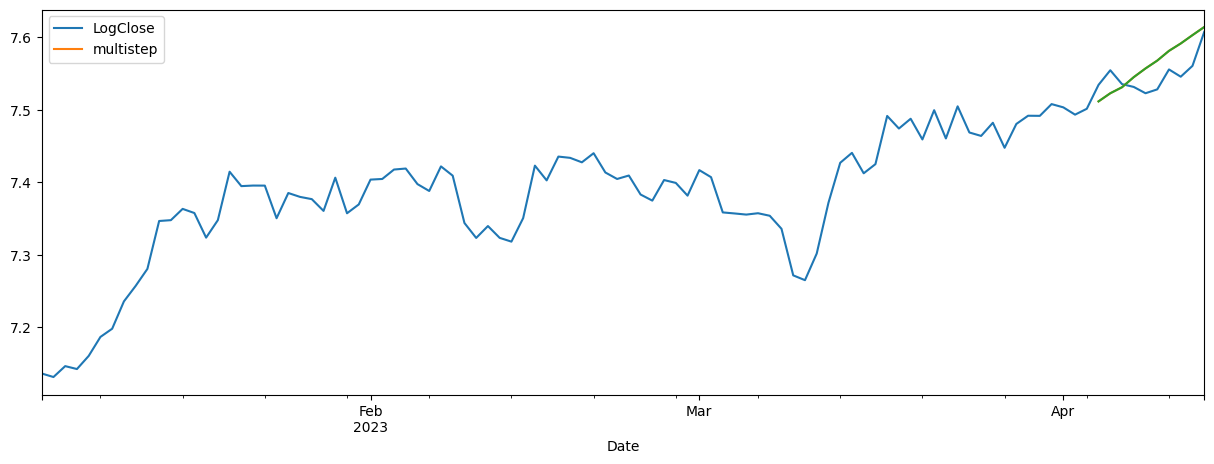

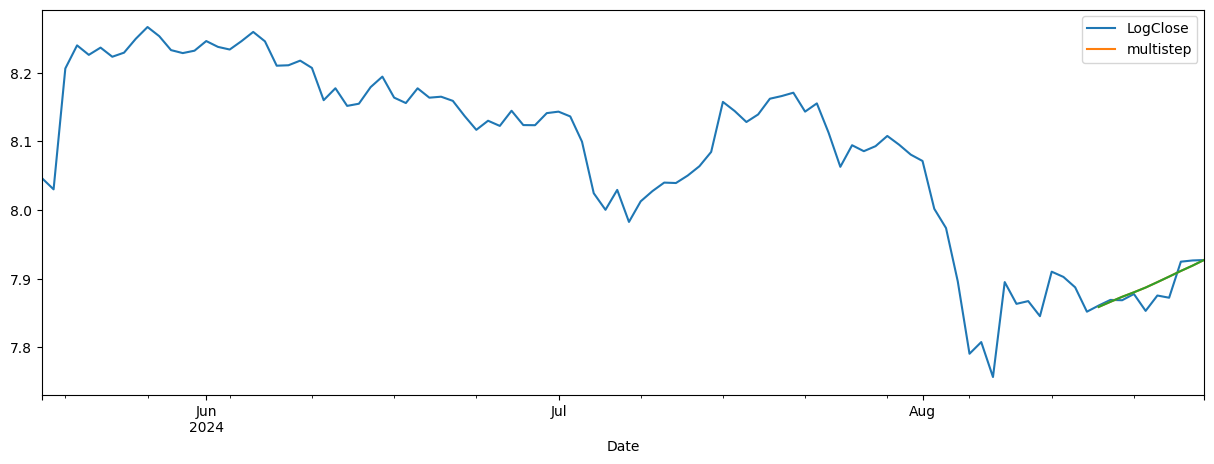

In [44]:
i = 328
real_100d = []
pred_100d = []
while i <= len(df):
    temp = df[:i].copy()
    
    i = i + 500
    
    Ntest = 10
    train = temp.iloc[:-Ntest]
    test = temp.iloc[-Ntest:]
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[['DiffLogClose']])
    test_scaled = scaler.fit_transform(test[['DiffLogClose']])
    
    train_idx = temp.index <= train.index[-1]
    test_idx = temp.index > train.index[-1]
    
    temp.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
    temp.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()
    
    series = temp['ScaledLogReturn'].dropna().to_numpy()

    T = 100
    X = []
    Y = []
    for t in range(len(series) - T):
        x = series[t:t + T]
        X.append(x)
        y = series[t + T]
        Y.append(y)
    X = np.array(X).reshape(-1,T)
    Y = np.array(Y)
    N = len(X)
    print('X.shape', X.shape, 'Y.shape', Y.shape)
    
    Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
    Xtest, Ytest = X[-Ntest:], Y[-Ntest:]
    
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=2)
    grid_result = grid.fit(Xtrain, Ytrain,validation_data=(Xtest, Ytest))
    best_model = grid_result.best_estimator_
    
    last_train = train.iloc[-1]['LogClose']
    
    # multi-step forecast
    multistep_predictions = []
    
    # first test input
    last_x = Xtest[0]
    
    while len(multistep_predictions) < Ntest:
      p = best_model.predict(last_x.reshape(1, -1))[0]
      
      # update the predictions list
      multistep_predictions.append(p)
      
      # make the new input
      last_x = np.roll(last_x, -1)
      last_x[-1] = p
    
    multistep_predictions = np.array(multistep_predictions)
    multistep_predictions = scaler.inverse_transform(multistep_predictions.reshape(-1, 1)).flatten()
    
    temp.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)
    
    predicted_temp = np.array(np.exp(temp.loc[test_idx,'multistep']))
    real_temp = np.array(temp.loc[test_idx,'Close'])
    
    temp.iloc[-100:][['LogClose', 'multistep']].plot(figsize=(15, 5));
    plt.plot(temp.loc[test_idx, 'multistep'])
    
    pred_100d.append(predicted_temp)
    real_100d.append(real_temp)

In [35]:
predicted_10d = pred_10d
real_10d = real_10d

In [46]:
predicted_50d = pred_50d
real_50d = real_50d

In [47]:
predicted_100d = pred_100d
real_100d = real_100d

In [48]:
print("R2 score for 10, 50 and 100 days are:",round(r2_score(real_10d, predicted_10d),4), round(r2_score(real_50d, predicted_50d),4),round(r2_score(real_100d, predicted_100d),4))

R2 score for 10, 50 and 100 days are: 0.9957 0.9955 0.9933


In [49]:
print("MAPE score for 10, 50 and 100 days are:",round(mean_absolute_percentage_error(real_10d, predicted_10d)*100,2),round(mean_absolute_percentage_error(real_50d, predicted_50d)*100,2),round(mean_absolute_percentage_error(real_100d, predicted_100d)*100,2))

MAPE score for 10, 50 and 100 days are: 2.15 2.15 2.6


In [50]:
print("MAE scores for 10, 50 and 100 days are:",round(mean_absolute_error(real_10d, predicted_10d),2),round(mean_absolute_error(real_50d, predicted_50d),2),round(mean_absolute_error(real_100d, predicted_100d),2))

MAE scores for 10, 50 and 100 days are: 54.71 54.23 66.87


In [51]:
print("MSE scores for 10, 50 and 100 days are:",round(mean_squared_error(real_10d, predicted_10d),2),round(mean_squared_error(real_50d, predicted_50d),2),round(mean_squared_error(real_100d, predicted_100d),2))

MSE scores for 10, 50 and 100 days are: 8377.61 8743.18 13080.93


In [52]:
print("RMSE scores for 10, 50 and 100 days are:",round(root_mean_squared_error(real_10d, predicted_10d),2),round(root_mean_squared_error(real_50d, predicted_50d),2),round(root_mean_squared_error(real_100d, predicted_100d),2))

RMSE scores for 10, 50 and 100 days are: 77.05 77.37 96.94
